In [1]:
from graphviz import Digraph
import inspect
import math
import random

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
    
  def __repr__(self):
    return f"Value(data={self.data})"
    
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other
    
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data ** other, (self, ), f'**{other}')
    def _backward():
      self.grad += other * (self.data**(other - 1)) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)
  
  def __rsub__(self, other):
    return other - self
    
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += math.exp(x) * out.grad
    out._backward = _backward
    return out
    
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo): node._backward()

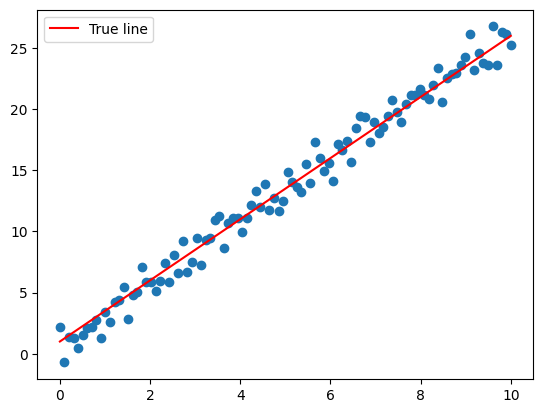

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 100
slope = 2.5
intercept = 1.0
noise_std = 1.0

# Generate data
xs = np.linspace(0, 10, n)
ys = slope * xs + intercept + np.random.normal(0, noise_std, n)

# Optional: visualize
plt.scatter(xs, ys)
plt.plot(xs, slope * xs + intercept, color='red', label='True line')
plt.legend()
plt.show()

xs = xs.tolist()
ys = ys.tolist()

In [12]:
a = Value(random.uniform(-1, 1))
b = Value(random.uniform(-1, 1))

for k in range(1000):
  # forward pass
  ypred = [a * Value(x) + b for x in xs]
  loss = sum((yp - Value(y))**2 for yp, y in zip(ypred, ys)) / len(xs)

  # backward pass
  for p in (a, b):
    p.grad = 0.0
  loss.backward()

  # update
  for p in (a, b):
    p.data += -0.01 * p.grad
    
  print(k, loss.data)

print(a.data, b.data)

0 357.26751278442214
1 36.32225596771513
2 4.490513563994198
3 1.3333682749145583
4 1.0202014809959834
5 0.9891039788813885
6 0.9859827888882557
7 0.985636685826086
8 0.9855661808090956
9 0.9855233681934401
10 0.9854836568761673
11 0.9854446043715478
12 0.9854059649528855
13 0.9853677108049154
14 0.9853298357591699
15 0.9852923358279047
16 0.9852552072730927
17 0.9852184464145787
18 0.9851820496107208
19 0.9851460132561435
20 0.9851103337811999
21 0.9850750076515964
22 0.9850400313680407
23 0.9850054014658927
24 0.9849711145148277
25 0.9849371671184893
26 0.9849035559141581
27 0.9848702775724166
28 0.9848373287968185
29 0.9848047063235649
30 0.9847724069211785
31 0.9847404273901832
32 0.9847087645627903
33 0.9846774153025822
34 0.9846463765042025
35 0.9846156450930454
36 0.984585218024959
37 0.9845550922859339
38 0.9845252648918122
39 0.9844957328879873
40 0.984466493349115
41 0.9844375433788192
42 0.9844088801094103
43 0.9843805007015969
44 0.9843524023442055
45 0.9843245822539034
46 

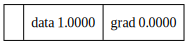

In [31]:
c = Value(1.0)
draw_dot(c)